Notebook for TPD submisison

### Imports and settings

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib widget
import time
import numpy as np
from aeromaps.core.process import create_process
from aeromaps.core.models import models_complex
from aeromaps.models.air_transport.aircraft_fleet_and_operations.fleet.fleet_model import (
    Fleet,
    AircraftParameters,
    Aircraft,
)


custom_params = {"axes.spines.right": False, "axes.spines.top": False}

# Update Matplotlib rcParams
plt.rcParams.update(custom_params)

# Introduction

Simple MACC Curve

In [2]:
# Generate random data for simple MAC
np.random.seed(0)
data = {
    "names": ["A", "B", "C", "D", "E"],
    "abatement_effective": [5, 1, 2, 3, 4],
    "carbon_abatement_cost": [-20, 20, 100, 28, 50],
}

df = pd.DataFrame(data).set_index("names")

maccpos_df = df.sort_values(by="carbon_abatement_cost")

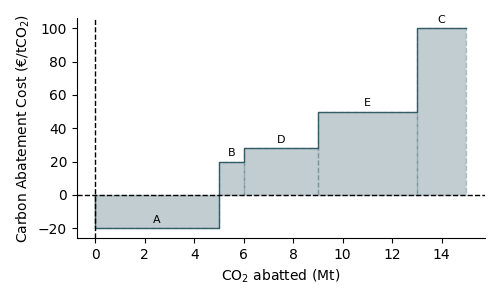

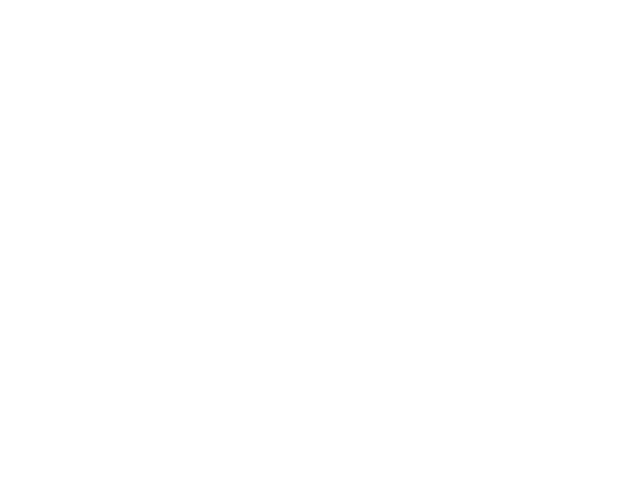

In [3]:
plt.clf()
fig, ax = plt.subplots(figsize=(5, 3))

##### POS ######

heights_pos = maccpos_df["carbon_abatement_cost"].to_list()
names_pos = maccpos_df.index.to_list()
heights_pos.insert(0, 0)
heights_pos.append(heights_pos[-1])

# # MAx effective maccpos
widths_effective_pos = maccpos_df["abatement_effective"].to_list()
widths_effective_pos.insert(0, 0)
widths_effective_pos.append(widths_effective_pos[-1])


maccpos_curve = ax.step(
    np.cumsum(widths_effective_pos) - widths_effective_pos,
    heights_pos,
    where="post",
    color="#335C67",
    label="Marginal abatement cost",
    linewidth=1,
)

for i in range(len(widths_effective_pos) - 2):
    x_position = (np.cumsum(widths_effective_pos)[i] + np.cumsum(widths_effective_pos)[i + 1]) / 2
    y_position = min(2000 - 10, heights_pos[i + 1] + 5)
    ax.text(
        x_position,
        y_position,
        f"{names_pos[i]}",
        rotation=0,
        size=8,
        ha="center",
        va="center",
    )


for i in range(0, (len(widths_effective_pos) - 2)):
    # Create a polygon for each step
    polygon = plt.Polygon(
        [
            (np.cumsum(widths_effective_pos)[i], 0),
            (np.cumsum(widths_effective_pos)[i], heights_pos[i + 1]),
            (np.cumsum(widths_effective_pos)[i + 1], heights_pos[i + 1]),
            (np.cumsum(widths_effective_pos)[i + 1], 0),
        ],
        closed=True,
        alpha=0.3,
        facecolor="#335C67",
        edgecolor="#335C67",
        linewidth=1,
        linestyle="--",
    )
    ax.add_patch(polygon)


ax.set_ylabel("Carbon Abatement Cost (€/t$\mathregular{CO_2}$)")
ax.set_xlabel("$\mathregular{CO_2}$ abatted (Mt)")

ax.axhline(0, color="black", linestyle="--", linewidth=1)

ax.axvline(0, color="black", linestyle="--", linewidth=1)

fig.tight_layout()
fig.savefig("TPD images/simple_cac.pdf")
plt.show()

# Scenario initialisation

The first phase corresponds to running a first, central scenario with AeroMAPS. Other runs ar performed afterwards.

In [4]:
process = create_process(
    models=models_complex,
    use_fleet_model=True,
    add_examples_aircraft_and_subcategory=False,
)

### Air traffic evolution

As of April 2024, AeroMAPS is considering an exgenous growth rate.
For the purposes of this article, an uniform growth rate of 3% is set. This is significantly lower from industry prospects such as [Airbus GMF: 3.6%](https://www.airbus.com/en/products-services/commercial-aircraft/market/global-market-forecast) or [Boeing CMO: 3.8%](https://www.boeing.com/content/dam/boeing/boeingdotcom/market/assets/downloads/CMO_2022_Report_FINAL_v02.pdf), but higher than [IEA Net Zero: 2.1% (2019 as base year)](https://www.iea.org/reports/net-zero-roadmap-a-global-pathway-to-keep-the-15-0c-goal-in-reach).


In [5]:
## Growth rate by category [%]
process.parameters.cagr_passenger_short_range_reference_periods = []
process.parameters.cagr_passenger_short_range_reference_periods_values = [3.0]
process.parameters.cagr_passenger_medium_range_reference_periods = []
process.parameters.cagr_passenger_medium_range_reference_periods_values = [3.0]
process.parameters.cagr_passenger_long_range_reference_periods = []
process.parameters.cagr_passenger_long_range_reference_periods_values = [3.0]
process.parameters.cagr_freight_reference_periods = []
process.parameters.cagr_freight_reference_periods_values = [3.0]

### Aircraft fleet

**Hypotheses considered for aircraft DOC and new aircraft introduction:**
The previously defined air traffic is flown by the default AeroMAPS fleet, and new aircraft. 

- A default fleet: an "old" and a "recent" aircraft for three markets: Short (<1500 km), Medium (1500-4000 km) and Long Range (>4000 km). 
- New aircraft are introduced
    - <u>Short Range:</u>
        - Hydrogen aircraft in 2035
    - <u>Medium Range:</u>
        - Drop-in aircraft in 2030
        - Hydrogen aircraft in 2045  
    - <u>Long Range:</u>
        - Drop-in aircraft in 2030
        - Drop-in aircraft in 2045
        
    - Efficiency assumptions: drop in aircraft introduced in 2030 use 20% less energy than the current ("recent"), the second long-range dropin aircraft introduced in 2045 uses 30% less energy than the "recent. Hydrogen aircraft uses the same ammount of energy than the recent aircraft.
    - Aircraft RC and NRC cost assumption are based on [this article](https://www.eucass.eu/doi/EUCASS2023-593.pdf), but these parameter are not used in this article. There is currently <u>no automated link between RC+NRC and DOC on AeroMAPS </u>. Consistent values are filed nevertheless. Same for ASK per year per A/C.
    
    
    - Aircraft DOC are obtained using the same article and regrouped in two categories
        - DOC-ENERGY is computed using the energy consumption of the aircraft and the MFSP of the corresponding energy (see below). 
        - DOC-NON-ENERGY encompass all other direct operating Costs (Navigation, FA/Pilots, MRO,...). AeroMAPS requires the evolution of this parameter compared to the reference. For  information, the capital part represent around 16% of the total DOC-NE and other costs 84%. A composite evolution can therefore be computed. The capital part is obtained (outside of AeroMAPS) by computing an equivalent annual cost (**EAC**), using an annuity factor of 0.07 (computed for 25 years, under a 5% Interest rate). It can be modified to represent a increase in aircraft cost or lifespan. ($\text{EAC} = \frac{CAP_{t0} \times i}{1 - (1 + i)^{-n}} $). For the time being, the DOC-NE of drop-,n aircraft is left unchanged, and the DOC NE of both hydrogen aircraft is  set at 106% and 110% of the basis according to [Hoelzen et al.](https://www.sciencedirect.com/science/article/pii/S0360319921043184#fig2)
        
    
    

    
        
- Aircraft fleet renewal rates are set to 25 years. It corresponds to both the aircraft life and the duration necessary to renew the whole fleet with current fleet renewal models of AeroMAPS.






In [6]:
# Aircraft fleet

## Initialization
fleet = process.fleet

## Short Range aircraft
short_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2035,
    consumption_evolution=0.0,
    nox_evolution=-75.0,
    soot_evolution=-100.0,
    doc_non_energy_evolution=10.0,
    cruise_altitude=12000.0,
    ask_year=280000000,
    rc_cost=50000000,
    nrc_cost=10000000000.0,
)
short_range_aircraft = Aircraft(
    "New SR-H2", parameters=short_range_aircraft_params, energy_type="HYDROGEN"
)
fleet.categories["Short Range"].subcategories[0].add_aircraft(aircraft=short_range_aircraft)

## Medium Range
medium_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2030,
    consumption_evolution=-20.0,
    nox_evolution=0.0,
    soot_evolution=0.0,
    doc_non_energy_evolution=0.0,
    cruise_altitude=12000.0,
    ask_year=352000000.0,
    rc_cost=60000000.0,
    nrc_cost=10000000000.0,
)
medium_range_aircraft = Aircraft(
    "New MR-DI", parameters=medium_range_aircraft_params, energy_type="DROP_IN_FUEL"
)
fleet.categories["Medium Range"].subcategories[0].add_aircraft(aircraft=medium_range_aircraft)

## Medium Range
medium_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2045,
    consumption_evolution=0.0,
    nox_evolution=-75.0,
    soot_evolution=-100,
    doc_non_energy_evolution=10.0,
    cruise_altitude=12000.0,
    ask_year=352000000.0,
    rc_cost=6600000.0,
    nrc_cost=15000000000.0,
)
medium_range_aircraft = Aircraft(
    "New MR-H2", parameters=medium_range_aircraft_params, energy_type="HYDROGEN"
)
fleet.categories["Medium Range"].subcategories[0].add_aircraft(aircraft=medium_range_aircraft)

## Long Range
long_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2030,
    consumption_evolution=-20.0,
    nox_evolution=0.0,
    soot_evolution=0.0,
    doc_non_energy_evolution=0.0,
    cruise_altitude=12000.0,
    ask_year=912000000.0,
    rc_cost=150000000.0,
    nrc_cost=25000000000.0,
)
long_range_aircraft = Aircraft(
    "New LR-DI", parameters=long_range_aircraft_params, energy_type="DROP_IN_FUEL"
)
fleet.categories["Long Range"].subcategories[0].add_aircraft(aircraft=long_range_aircraft)


## Long Range
long_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2045,
    consumption_evolution=-30.0,
    nox_evolution=0.0,
    soot_evolution=0.0,
    doc_non_energy_evolution=0.0,
    cruise_altitude=12000.0,
    ask_year=912000000.0,
    rc_cost=150000000.0,
    nrc_cost=25000000000.0,
)
long_range_aircraft = Aircraft(
    "New LR-DI2", parameters=long_range_aircraft_params, energy_type="DROP_IN_FUEL"
)
fleet.categories["Long Range"].subcategories[0].add_aircraft(aircraft=long_range_aircraft)


## Fleet renewal
fleet.categories["Short Range"].parameters.life = 25
fleet.categories["Medium Range"].parameters.life = 25
fleet.categories["Long Range"].parameters.life = 25

### Operational improvements

Operational improvements are considered via two opportunities. 
- Load factor improvement: improvement to 89% at the end of the scenario.
- Operational efficiency (better ATM, aircrfat MRO and operational optimisation): improvement of 8% in 25y. 

Cost savings incur through the fuel savings. However, it could come at an extra cost (non-energy). This parameter is modelled, but not considered in this article due to lack of specific informations to the best of our knowldege.


In [7]:
process.parameters.load_factor_end_year = 89  # 2019 value: 82.399312

In [8]:
# Aircraft fleet and operation evolution - Operations

## Values for setting the logistic function
process.parameters.operations_final_gain = 8.0  # [%]
process.parameters.operations_start_year = 2025
process.parameters.operations_duration = 25.0

### Energy

***Pathway choices:***
An energy mix is defined, relatively arbitraily, but inspired from [ReFuel-EU](https://eur-lex.europa.eu/legal-content/EN/TXT/HTML/?uri=OJ:L_202302405#d1e35-29-1) blending mandates. Sythetic fuels are defined as fuels of non-biological origin, either hydrogen or e-fuels, produced with DAC.

| Year | SAF (%) | incl. Synthetic Fuels (%) |
|---|---|---|
| 2025 | 2 | 0 |
| 2030 | 6 | 1.2 |
| 2035 | 20 | 5 |
| 2040 | 34 | 10 |
| 2045 | 42 | 15 |
| 2050 | 70 | 35 |

It is easy to define blending shares for drop-in fuels. However, hydrogen consumption is more dependant on how many hydrogen aircraft are used.
We therefore consider that the Refuel-EU blending mandates are applied directly to the dropin fuels (more ambitious than refuel-EU).

Within biofuel pathways, shares are defined according to their biomass availability.

Hydrogen production starts from the current [share](https://iea.blob.core.windows.net/assets/c5bc75b1-9e4d-460d-9056-6e8e626a11c4/GlobalHydrogenReview2022.pdf) (p71) follows repartition of [NZE](https://www.iea.org/reports/hydrogen-2156) until 2050. Note that these are industry wide productions, and aviation might larger share of electrolysis hydrogen.

| Year | Coal (%) | Coal + CCS (%) | Gas (%) | Gas+CCS (%) | Electrolysis (%) |
|---|---|---|---|---|---|
| 2022 | 25 | 0.25 | 75 | 0.75 | 0 |
| 2030 | 13.4 | 3 | 40 | 9  | 34.6 |
| 2035 | 7.6 | 3.9 | 22.6 | 11.9 | 54 |
| 2050 | 1 | 5 | 3 | 15 | 76 |


***Emission factors & availabilities:*** All emissions factors/energy availabilities are default AeroMAPS median emission factors (see documentation).


***Cost Parameters:***

- **Biofuels:** All values for biofuels are derived from a litterature review (refer to resources/cost_data/Biomass_Data.xlsx); Values are set to the median value and no evolution (such as learning rates) is assumed. Municipal solid waste feedstock is considered as free by the sources reviewed, although it could be diffrent once there is a demand for it.

| Pathway | Capex (€/(kg/day)) | Opex (€/L) | Feedstock Cost (cts €/MJ biomass) |
|---|---|---|---|
| HEFA-FOG | 491 | 0.17 | 1.27 |
| HEFA-Others | 654 | 0.13 | 1.22 |
| FT-MSW | 3042 | 0.29 | 0 |
| FT-Others | 2043 | 0.27 | 0.7 |
| AtJ | 1547 | 0.21 | 1.02 |

- **Hydrogen - Electrolysis:** (refer to resources/cost_data/Hydrogen_based_process.xlsx). 
    - Values for OPEX base on a litterature review, mostly relying on an institutional report from the [UK department of Energy](https://www.gov.uk/government/publications/hydrogen-production-costs-2021). Time dynamics represented by a transition from pessimistic in 2020 to median in 2030 to optimistic in 2050 and beyond. 
    - Values  and time Dynamic for CAPEX and efficiency using data from an [external litterature review](https://h2.pik-potsdam.de/H2Dash/)
    - Both dedicated renewable and grid electricity are used in this work.

| Year | Capex (€/(kg $H_2$/day)) | Variable Opex (€/kg $H_2$) | Fixed Opex (€/(kg $H_2$/day)/year)  | Efficiency (%) |
|:---:|:---:|:---:|:---:|:---:|
| 2020 | 533 | 0.3 | 25 | 0.64 |
| 2030 | 355 | 0.19 | 21 | 0.66 |
| 2040 | 261 |  |  |  |
| 2050 | 210 | 0.12 | 20 | 0.72 |

- **Hydrogen - Other pathways:** Based on literature review (see supplementary material). Fixed cost references based on [IEA Global Hydrogen Review 2021](https://iea.blob.core.windows.net/assets/2ceb17b8-474f-4154-aab5-4d898f735c17/IEAGHRassumptions_final.pdf). CCS is assumed to cost 22.5€/t$CO_2$

| Pathway | Capex (€/(kg/day)) | Fixed Opex (€/(kg/day)/year)  | Efficiency (%) | 
|:---:|:---:|:---:|:---:|
| Gas reforming | 917 | 43.1 | 76 |
| Gas reforming + CCS | 1728 | 69.1 | 69 | 
| Coal gasification | 2304 | 115.2 | 60 | 
| Coal gasification + CCS | 2399 | 119.95 | 58 |



- **Hydrogen - Liquefaction and transport:**
    Hydrogen production and transportation is considered similarly for all the production pathways. Based on literature review (see supplementary material) presented in [hoelzen et al.](https://www.sciencedirect.com/science/article/pii/S0360319921043184). Prices swicth from pessimistic to median to optimistic values in 2020-2035-2050, as well as efficiencies, which are defined by the ratio of the hydrogen energy with this value plus the energy necessary to liquefy the hydrogen. Opex are taken as 4% of Capex annually. Transport is weakly modelled and assumed to represent 10% of the total hydrogen production cost.
| Year | Capex (€/(kg $H_2$/day)) | Efficiency (%) |
|---|---|---|
| 2020 | 2248 | 0.75 |
| 2030 | 1457 | 0.82 |
| 2050 | 899 | 0.83 |


- **Efuels:** Based on literature review (refer to resources/cost_data/Hydrogen_based_process.xlsx). Time dynamics represented by a transition from pessimistic in 2020 to median in 2035 to optimistic in 2050 and beyond. Both dedicated renewable and grid electricity are used in this work.
    - Values for CO2 DAC taken from a litterature review.  2020 and 2030 value based on the trajcetory taken by [Ueckerdt](https://www.nature.com/articles/s41558-021-01032-7), but 2050 value is capped at 100 USD for consistency with other sources reviewed. 
| Year | Capex (€/(kg $H_2$/day)) | Opex (€/L) | $H_2$-> PtL efficiency (%) | Specific $CO_2$ (kg/L) | CO2 DAC Cost (€/t) |
|---|---|---|---|---|---|
| 2020 | 2496 | 0.34 | 74 | 4.3 | 460 |
| 2035 | 1528 | 0.30 | 74 | 3.58 | 150 |
| 2050 | 510 | 0.20 | 74 | 2.55 | 90 |

**Hypotheses considered for energy inputs:**

- **Electricity:** Electricity is considered via two options. 
    - *Grid*: Grid electricity input is assumed to cost 70€ per MWh in 2019, as a coarse mean between [europe](https://ec.europa.eu/eurostat/databrowser/view/nrg_pc_205/default/table?lang=en) and [usa](https://www.statista.com/statistics/190680/us-industrial-consumer-price-estimates-for-retail-electricity-since-1970/). If considering grid electricity alows for high load factors, it requires the full consideration of backups and tranportation systems (infrastructure), meaning that considering per technology LCOE can be a major shortcomming. Grid electricity prices in 2050 are not widely available, but a value of 100€/Mwh seems to be adequate with respect to total system costs estimated by French network administrator [RTE](https://assets.rte-france.com/prod/2022-06/Futurs%20%C3%A9nerg%C3%A9tiques%202050%20_%20rapport%20complet.zip). Baseline emission factor for the grid is [450 g$CO_2$/KWh](https://ourworldindata.org/grapher/carbon-intensity-electricity?time=2019) and are arbitrarily set at 20 g$CO_2$/KWh in 2050, in line with total low-carbon system emissions of [RTE](https://assets.rte-france.com/prod/2022-06/. Intermediate points are set at 160g in 2030 and 40g in 2040.
    
    - *Dedicated renewables*: (refer to resources/cost_data/Hydrogen_based_process.xlsx)
        - Wind:
            | Year | LCOE (€/MWh) | EF (gCO2/kWh) | Load Factor (%) | 
            |---|---|---|---|
            | 2020 | 61 | 15 | 40 | 
            | 2030 | 58 | 13.5 | 43 | 
            | 2040 | 52 | 12.5 | N/A | 
            | 2050 | 46 | 11.5 | 45 | 
            
        - PV:
            | Year | LCOE (€/MWh) | EF (gCO2/kWh) | Load Factor (%) | 
            |---|---|---|---|
            | 2020 | 58 | 43 | 13 | 
            | 2030 | 37 | 36 | 14 | 
            | 2040 | 33 | 30 | N/A | 
            | 2050 | 26 | 21 | 14 | 
            

- **Fossil fuels**
    - Fossil based hydrogen (gas/coal) prices from [IEA Global Hydrogen Review 2021](https://iea.blob.core.windows.net/assets/2ceb17b8-474f-4154-aab5-4d898f735c17/IEAGHRassumptions_final.pdf), default values of AeroMAPS.
    
    - **Kerosene**: median of 2015-2019 Weekly U.S. Gulf Coast Kerosene-Type Jet Fuel Spot Price (refer to resources/cost_data/Biomass_data.xlsx); default aeromaps value.

    


In [9]:
# Energy settings: production choices

# Aircraft energy - Introduction of alternative drop-in fuels

## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
process.parameters.biofuel_share_reference_years = [2020, 2025, 2030, 2035, 2040,2045, 2050]
process.parameters.biofuel_share_reference_years_values = [0, 2, 4.8, 15, 24, 27, 35]
process.parameters.electrofuel_share_reference_years = [2020, 2025, 2030, 2035, 2040,2045, 2050]
process.parameters.electrofuel_share_reference_years_values = [0, 0, 1.2, 5, 10, 15, 35]


## Share of biofuel production pathways (the rest being completed by AtJ processes) [%]
process.parameters.biofuel_hefa_fog_share_reference_years = []
process.parameters.biofuel_hefa_fog_share_reference_years_values = [0.6]
process.parameters.biofuel_hefa_others_share_reference_years = []
process.parameters.biofuel_hefa_others_share_reference_years_values = [12.5]
process.parameters.biofuel_ft_others_share_reference_years = []
process.parameters.biofuel_ft_others_share_reference_years_values = [68.9]
process.parameters.biofuel_ft_msw_share_reference_years = []
process.parameters.biofuel_ft_msw_share_reference_years_values = [6.6]


## Share of hydrogen production pathways (the rest being completed by production via coal without CCS) [%]
## Distribution in 2019: Gas without CCS (71%), Coal without CCS (27%), Electrolysis (2%), Others with CCS (0%), Co-products not taken into account
process.parameters.hydrogen_electrolysis_share_reference_years = [2020, 2030, 2035, 2050]
process.parameters.hydrogen_electrolysis_share_reference_years_values = [0, 34.6, 54, 76]

process.parameters.hydrogen_gas_ccs_share_reference_years = [2020, 2030, 2035, 2050]
process.parameters.hydrogen_gas_ccs_share_reference_years_values = [0.75, 9, 11.9, 15]

process.parameters.hydrogen_coal_ccs_share_reference_years = [2020, 2030, 2035, 2050]
process.parameters.hydrogen_coal_ccs_share_reference_years_values = [0.25, 3, 3.9, 5]

process.parameters.hydrogen_gas_share_reference_years = [2020, 2030, 2035, 2050]
process.parameters.hydrogen_gas_share_reference_years_values = [75, 40, 22.6, 3]

In [10]:
# Energy settings: cost

# BIOFUELS
# ==> Default AeroMAPS values (see table above)

# HYDROGEN

## Electrolysis 
### Efficicency 
process.parameters.electrolysis_efficiency_reference_years = [2020, 2030, 2050]
process.parameters.electrolysis_efficiency_reference_years_values = [0.64, 0.66,0.72]
### CAPEX 
process.parameters.electrolyser_capex_reference_years = [2020, 2030, 2040, 2050]
process.parameters.electrolyser_capex_reference_years_values = [533, 355, 261, 210]
### Fixed OPEX
process.parameters.electrolyser_fixed_opex_reference_years = [2020, 2030, 2050]
process.parameters.electrolyser_fixed_opex_reference_years_values = [25.05, 20.57, 19.62]
### Variable OPEX
process.parameters.electrolyser_variable_opex_reference_years = [2020, 2030, 2050]
process.parameters.electrolyser_variable_opex_reference_years_values = [0.3, 0.19, 0.12]

## Fossil (Gas or Coal with or without CCS)
# ==> Default AeroMAPS values (see table above)

## Liquefaction
### CAPEX 
process.parameters.liquefier_capex_reference_years = [2020, 2030, 2050]
process.parameters.liquefier_capex_reference_years_values = [2248, 1457, 899]
### Efficicency 
process.parameters.liquefaction_efficiency_reference_years = [2020, 2030, 2050]
process.parameters.liquefaction_efficiency_reference_years_values = [0.75, 0.82, 0.83]


# ELECTROFUEL
### Efficicency 
process.parameters.electrofuel_hydrogen_efficiency_reference_years = [2020, 2030, 2050]
process.parameters.electrofuel_hydrogen_efficiency_reference_years_values = [0.74, 0.74,0.74]
### CAPEX 
process.parameters.electrofuel_capex_reference_years = [2020,2030,2050]
process.parameters.electrofuel_capex_reference_years_values = [2496, 1528, 510]

process.parameters.electrofuel_var_opex_reference_years = [2020,2030,2050]
process.parameters.electrofuel_var_opex_reference_years_values = [0.336, 0.296, 0.2]

process.parameters.electrofuel_specific_co2_reference_years = [2020,2030,2050]
process.parameters.electrofuel_specific_co2_reference_years_values = [4.30,3.58,2.552]

process.parameters.co2_cost_reference_years = [2020,2030,2050]
process.parameters.co2_cost_reference_years_values = [0.460, 0.150, 0.09]



# ENERGY INPUT PRICES
## Grid Electricity
# => LF=1

process.parameters.electricity_emission_factor_reference_years = [2020,2030,2040,2050]
process.parameters.electricity_emission_factor_reference_years_values = [429,160,40,20]

process.parameters.electricity_cost_reference_years = [2020,2050]
process.parameters.electricity_cost_reference_years_values = [0.08,0.1]

# # ## PV
# process.parameters.electricity_emission_factor_reference_years = [2020,2030,2040,2050]
# process.parameters.electricity_emission_factor_reference_years_values = [43,36,30,21]

# process.parameters.electricity_cost_reference_years = [2020,2030,2040,2050]
# process.parameters.electricity_cost_reference_years_values = [0.058, 0.037, 0.033, 0.026]

# process.parameters.electricity_load_factor_reference_years = [2020,2030,2050]
# process.parameters.electricity_load_factor_reference_years_values = [0.13,0.14,0.14]

# ## Wind
# process.parameters.electricity_emission_factor_reference_years = [2020,2030,2040,2050]
# process.parameters.electricity_emission_factor_reference_years_values = [15,13.5,12.5,11.5]

# process.parameters.electricity_cost_reference_years = [2020,2030,2040,2050]
# process.parameters.electricity_cost_reference_years_values = [0.061, 0.058, 0.052, 0.046]

# process.parameters.electricity_load_factor_reference_years = [2020,2030,2050]
# process.parameters.electricity_load_factor_reference_years_values = [0.4,0.43,0.45]


# Kerosene, Coal, Gas => Default values (see table)

In [11]:
# Cost parameters

## Carbon tax => Set at zero for MACC curves
process.parameters.carbon_tax_reference_years = [2020, 2030, 2040, 2050]
process.parameters.carbon_tax_reference_years_values = [
    0,
    0,
    0,
    0,
]

In [12]:
# Environmental limits

## Carbon budgets and Carbon Dioxide Removal [GtCO2]
process.parameters.net_carbon_budget = 850.0
process.parameters.carbon_dioxyde_removal_2100 = 285.0

In [13]:
# Allocation settings

## Aviation share of the global (equivalent) carbon budget [%]
process.parameters.aviation_carbon_budget_allocated_share = 2.6
process.parameters.aviation_equivalentcarbonbudget_allocated_share = 5.1

## Aviation share of the global energy resources (biomass and electricity) [%]
process.parameters.aviation_biomass_allocated_share = 5.0
process.parameters.aviation_electricity_allocated_share = 5.0

## Compute

In [14]:
process.compute()

interactive(children=(IntSlider(value=2035, description='Year:', max=2050, min=2019), Dropdown(description='Me…

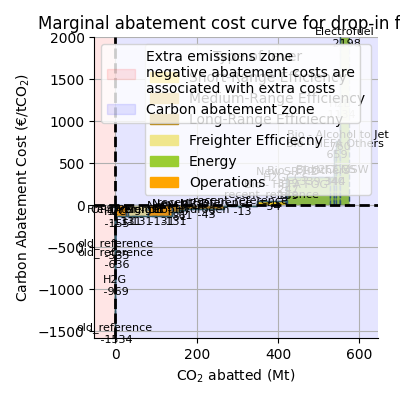

In [15]:
process.plot("annual_MACC")

interactive(children=(IntSlider(value=2034, description='year', max=2050, min=2019), Output()), _dom_classes=(…

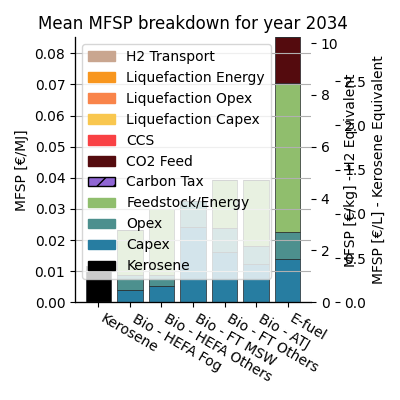

In [16]:
process.plot("mfsp_detailled_year")

In [17]:
process.vector_outputs_df["ask_hydrogen"]/process.vector_outputs_df["ask"]*100

2000     0.000000
2001     0.000000
2002     0.000000
2003     0.000000
2004     0.000000
2005     0.000000
2006     0.000000
2007     0.000000
2008     0.000000
2009     0.000000
2010     0.000000
2011     0.000000
2012     0.000000
2013     0.000000
2014     0.000000
2015     0.000000
2016     0.000000
2017     0.000000
2018     0.000000
2019     0.000000
2020     0.000000
2021     0.000000
2022     0.000000
2023     0.000000
2024     0.000000
2025     0.000000
2026     0.000000
2027     0.000000
2028     0.000000
2029     0.000000
2030     0.000000
2031     0.000000
2032     0.000000
2033     0.000000
2034     0.000000
2035     0.544000
2036     0.737316
2037     0.996759
2038     1.342862
2039     1.800882
2040     2.400619
2041     3.175114
2042     4.157590
2043     5.376045
2044     6.845504
2045     9.261094
2046    11.432226
2047    13.829817
2048    16.389327
2049    19.043169
2050    21.738763
dtype: float64